In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


80 ID番号への変換

In [2]:
import pandas as pd
from collections import defaultdict
import string


class ID():
    def __init__(self, data):
        self.train_dict = defaultdict(int)
        self.id_list = []
        self.id_dict = dict()
        self.make_id(data)

    def make_id(self, data):
        for line in data:
            words = line.translate(table).split()
            for word in words:
                self.train_dict[word] += 1
        calc_dict = dict(self.train_dict)
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)
        for i, (trg_word, freq) in enumerate(sort_list):
            if freq >= 2:
                self.id_list.append((trg_word, i+1))
            else:
                self.id_list.append((trg_word, 0))
        self.id_dict = dict(self.id_list)

    def return_id(self, line):
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec


table = str.maketrans(string.punctuation, ' '*len(string.punctuation))

header_name = ['TITLE', 'CATEGORY']
train_file = "./drive/MyDrive/data/train.txt"
train_data = pd.read_csv(train_file, header=None,
                         sep='\t', names=header_name)
w2id = ID(train_data['TITLE'])
test_vec = w2id.return_id(train_data["TITLE"][10])
print(train_data["TITLE"][10])
print(test_vec)

MARKET EYE-Indian bond yields inch higher tracking US peers, oil
[4221, 0, 374, 433, 3567, 166, 5136, 7, 0, 167]


In [3]:
# 追加
import numpy as np
from gensim.models import KeyedVectors
import torch

model = KeyedVectors.load_word2vec_format('./drive/MyDrive/data/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(w2id.id_dict.keys())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(w2id.id_dict.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'learned word num: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

learned word num: 16350 / 17057
torch.Size([17057, 300])


81 RNNによる予測

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn import functional as F

class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
        super().__init__()
        self.hid_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weight != None:
            self.emb = nn.Embedding.from_pretrained(emb_weight, padding_idx=pad_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        # self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers,
                          nonlinearity="tanh", batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hid_size,device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:  
          self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
          self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self,x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        out = self.fc(self.drop(max_pool.squeeze(2)))
        return out

class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }


train = pd.read_csv("./drive/MyDrive/data/train.txt", sep='\t')
valid = pd.read_csv("./drive/MyDrive/data/valid.txt", sep='\t')
test = pd.read_csv("./drive/MyDrive/data/test.txt", sep='\t')

category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)


82 確率的勾配降下法による学習

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time
from torch import optim
import numpy as np
from matplotlib import pyplot as plt


def calc_loss_acc(model, dataset, device=None, criterion=None):
    # model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None):
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)
    # dataloader_valid = DataLoader(
    #     dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')
    return {
        "train": log_train,
        "valid": log_valid
    }


def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig("83.png")



83 ミニバッチ化・GPU上での学習

In [6]:
class Padseq():
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1, loss_train: 1.1149, accuracy_train: 0.5516, loss_valid: 1.1326, accuracy_valid: 0.5299, train_time: 1.0442sec
epoch: 2, loss_train: 1.0757, accuracy_train: 0.5879, loss_valid: 1.0979, accuracy_valid: 0.5621, train_time: 0.4865sec
epoch: 3, loss_train: 1.0376, accuracy_train: 0.6155, loss_valid: 1.0621, accuracy_valid: 0.5838, train_time: 0.4787sec
epoch: 4, loss_train: 1.0072, accuracy_train: 0.5926, loss_valid: 1.0494, accuracy_valid: 0.5591, train_time: 0.4748sec
epoch: 5, loss_train: 0.9735, accuracy_train: 0.6007, loss_valid: 1.0325, accuracy_valid: 0.5659, train_time: 0.4851sec
epoch: 6, loss_train: 0.8813, accuracy_train: 0.6701, loss_valid: 0.9422, accuracy_valid: 0.6355, train_time: 0.4800sec
epoch: 7, loss_train: 0.8185, accuracy_train: 0.7137, loss_valid: 0.8937, accuracy_valid: 0.6774, train_time: 0.4650sec
epoch: 8, loss_train: 0.8000, accuracy_train: 0.7013, loss_valid: 0.8999, accuracy_valid: 0.6662, train_time: 0.4834sec
epoch: 9, loss_train: 0.7901, accuracy_t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


accuracy (train)：0.760
accuracy (test)：0.707


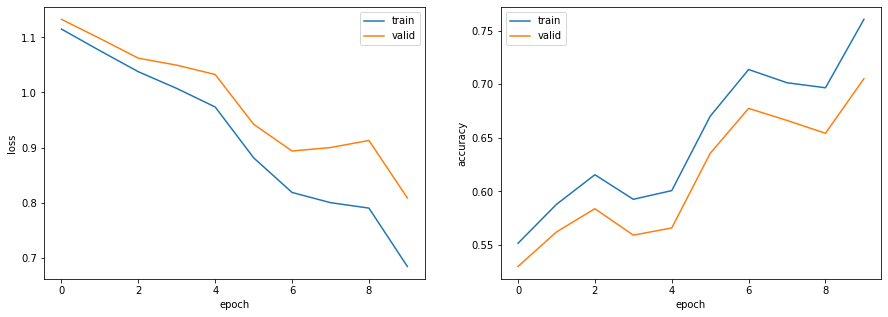

In [7]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

device = torch.device('cuda')

#def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log)
_, acc_train = calc_loss_acc(model, dataset_train,device)
_, acc_test = calc_loss_acc(model, dataset_test,device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')